<a href="https://colab.research.google.com/github/Inglam/Computer-Vision-EECS442-/blob/master/Enpei_PS10_Optical_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EECS 442 PS10: Optical Flow**

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Enpei Zhao, zepxyz



# Overview

In this problem set, You will implemente the optical flow network (PWN-Net) for estimating dense motion between a pair of images. 


# Starting

Run the following code to import the modules you'll need. 

In [ ]:
import os, math, random
from glob import glob
import numpy as np
import os.path
from os.path import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread # alternative to scipy.misc.imread
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


Download  and extract the Dataset.

In [ ]:
#!gdown https://drive.google.com/uc?id=1TxWFixzg3j0YRjR7cqksCAc_NDIBio1t
!wget http://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/psets/ps10_data/MPI-Sintel-442.zip
!unzip -q MPI-Sintel-442.zip #This might take a few minutes.

--2020-12-01 19:38:26--  http://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/psets/ps10_data/MPI-Sintel-442.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3949561120 (3.7G) [application/zip]
Saving to: ‘MPI-Sintel-442.zip’

MPI-Sintel-442.zip  100%[===================>]   3.68G  5.34MB/s    in 8m 53s  

2020-12-01 19:47:20 (7.06 MB/s) - ‘MPI-Sintel-442.zip’ saved [3949561120/3949561120]



Define some flow utility functions. You don't need to understand codes in this part for the problem set.

In [ ]:

TAG_CHAR = np.array([202021.25], np.float32)

def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            # Reshape data into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))

def writeFlow(filename,uv,v=None):
    """ Write optical flow to file.
    Expect input flow as shape H,W,2(u,v) if v is None.  
    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    nBands = 2

    if v is None:
        assert(uv.ndim == 3)
        assert(uv.shape[2] == 2)
        u = uv[:,:,0]
        v = uv[:,:,1]
    else:
        u = uv

    assert(u.shape == v.shape)
    height,width = u.shape
    f = open(filename,'wb')
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width*nBands))
    tmp[:,np.arange(width)*2] = u
    tmp[:,np.arange(width)*2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()


# ref: https://github.com/sampepose/flownet2-tf/
# blob/18f87081db44939414fc4a48834f9e0da3e69f4c/src/flowlib.py#L240
def visulize_flow_file(flow_filename, save_dir=None):
    flow_data = readFlow(flow_filename) #H，W，2
    #print(flow_data)
    img = flow2img(flow_data)
    plt.imshow(img)
    plt.show()
    if save_dir:
        idx = flow_filename.rfind("/") + 1
        plt.imsave(os.path.join(save_dir, "%s-vis.png" % flow_filename[idx:-4]), img)
def visualize_flow_array(flow_data, plot=True, title = None):
    """
    flow_data: array of shape H,W,2
    """
    img = flow2img(flow_data)
    if plot:
        plt.imshow(img)
        plt.axis('off')
        if title:
          plt.title(title)
        plt.show()
    return img

def flow2img(flow_data):
    """
    convert optical flow into color image
    :param flow_data:
    :return: color image
    """
    # print(flow_data.shape)
    # print(type(flow_data))
    u = flow_data[:, :, 0]
    v = flow_data[:, :, 1]

    UNKNOW_FLOW_THRESHOLD = 1e7
    pr1 = abs(u) > UNKNOW_FLOW_THRESHOLD
    pr2 = abs(v) > UNKNOW_FLOW_THRESHOLD
    idx_unknown = (pr1 | pr2)
    u[idx_unknown] = v[idx_unknown] = 0

    # get max value in each direction
    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.
    maxu = max(maxu, np.max(u))
    maxv = max(maxv, np.max(v))
    minu = min(minu, np.min(u))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))
    #print(maxrad)
    u = u / maxrad + np.finfo(float).eps
    v = v / maxrad + np.finfo(float).eps

    img = compute_color(u, v)

    idx = np.repeat(idx_unknown[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: horizontal optical flow
    :param v: vertical optical flow
    :return:
    """

    height, width = u.shape
    img = np.zeros((height, width, 3))

    NAN_idx = np.isnan(u) | np.isnan(v)
    u[NAN_idx] = v[NAN_idx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel, 1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0 - 1] / 255
        col1 = tmp[k1 - 1] / 255
        col = (1 - f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col * (1 - NAN_idx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col + YG, 0] = 255 - np.transpose(np.floor(255 * np.arange(0, YG) / YG))
    colorwheel[col:col + YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col + GC, 1] = 255
    colorwheel[col:col + GC, 2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col + CB, 1] = 255 - np.transpose(np.floor(255 * np.arange(0, CB) / CB))
    colorwheel[col:col + CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col + BM, 2] = 255
    colorwheel[col:col + BM, 0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col + MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col + MR, 0] = 255

    return colorwheel

# fram utils
def read_gen(file_name):
    ext = splitext(file_name)[-1]
    if ext == '.png' or ext == '.jpeg' or ext == '.ppm' or ext == '.jpg':
        im = imread(file_name)
        if im.shape[2] > 3:
            return im[:,:,:3]
        else:
            return im
    elif ext == '.bin' or ext == '.raw':
        return np.load(file_name)
    elif ext == '.flo':
        return readFlow(file_name).astype(np.float32)
    return []

Define the data augmentation functions, dataset and dataloader.

In [ ]:
class StaticRandomCrop(object):
    def __init__(self, image_size, crop_size):
        self.th, self.tw = crop_size
        h, w = image_size
        self.h1 = random.randint(0, h - self.th)
        self.w1 = random.randint(0, w - self.tw)

    def __call__(self, img):
        return img[self.h1:(self.h1+self.th), self.w1:(self.w1+self.tw),:]

class StaticCenterCrop(object):
    def __init__(self, image_size, crop_size):
        self.th, self.tw = crop_size
        self.h, self.w = image_size
    def __call__(self, img):
        return img[(self.h-self.th)//2:(self.h+self.th)//2, (self.w-self.tw)//2:(self.w+self.tw)//2,:]

class MpiSintel(data.Dataset):
    def __init__(self,crop_size=[384, 512], render_size=[384, 1024], train = False, root = '', dstype = 'clean'):

        flow_root = join(root, 'flow')
        image_root = join(root, dstype)

        self.crop_size = crop_size
        self.render_size = render_size
        self.train = train
        file_list = sorted(glob(join(flow_root, '*/*.flo')))
        #Randomly select out 100 samples for test set
        import random
        random.seed(30)
        random.shuffle(file_list)
        if self.train:
            file_list = file_list[:-100]
        else:
            file_list = file_list[-100:]
        self.flow_list = []
        self.image_list = []

        for file in file_list:
            if 'test' in file:
                # print file
                continue

            fbase = file[len(flow_root)+1:]
            fprefix = fbase[:-8]
            fnum = int(fbase[-8:-4])

            img1 = join(image_root, fprefix + "%04d"%(fnum+0) + '.png')
            img2 = join(image_root, fprefix + "%04d"%(fnum+1) + '.png')

            if not isfile(img1) or not isfile(img2) or not isfile(file):
                continue

            self.image_list += [[img1, img2]]
            self.flow_list += [file]

        self.size = len(self.image_list)

        self.frame_size = read_gen(self.image_list[0][0]).shape

        if (self.render_size[0] < 0) or (self.render_size[1] < 0) or (self.frame_size[0]%64) or (self.frame_size[1]%64):
            self.render_size[0] = ( (self.frame_size[0])//64 ) * 64
            self.render_size[1] = ( (self.frame_size[1])//64 ) * 64


        assert (len(self.image_list) == len(self.flow_list))

    def __getitem__(self, index):
        
        index = index % self.size

        img1 = read_gen(self.image_list[index][0])
        img2 = read_gen(self.image_list[index][1])
        
        flow = read_gen(self.flow_list[index]) # H,W,2

        images = [img1, img2]
        image_size = img1.shape[:2]
        
        if self.train:
            #cropper = StaticCenterCrop(image_size, self.crop_size)
            #print(image_size,self.render_size)
            cropper = StaticRandomCrop(image_size, self.crop_size)
        else:
            #print(image_size,self.render_size)
            cropper = StaticCenterCrop(image_size, self.render_size)
        images = list(map(cropper, images)) #2,H,W,3 
        flow = cropper(flow)
        images = np.array(images).transpose(0,3,1,2)
        flow = flow.transpose(2,0,1) # 2,H,W

        images = torch.from_numpy(images.astype(np.float32))/255.
        flow = torch.from_numpy(flow.astype(np.float32))

        return images, flow # 2,3,H,W and 2,H,W

    def __len__(self):
        return self.size

class MpiSintelClean(MpiSintel):
    def __init__(self, crop_size=[384, 512], render_size=[384, 1024], train = False, root = ''):
        super(MpiSintelClean, self).__init__(train = train, root = root, dstype = 'clean')



In [ ]:
train_dataset = MpiSintelClean(crop_size = [384, 512],render_size = [384, 1024], train = True, root='/content/MPI-Sintel-442/training') # Return crops of size 384, 512
val_dataset = MpiSintelClean(crop_size = [384, 512],render_size = [384, 1024], train = False, root='/content/MPI-Sintel-442/training') # Return images of size 384,1024
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle = False)

overfit_dataset = torch.utils.data.Subset(val_dataset,[0])
overfit_dataloader = DataLoader(overfit_dataset, batch_size = 1, shuffle = False)

Define Loss and evaluation metrics.

In [ ]:
import torch
import torch.nn as nn
import math

def EPE(input_flow, target_flow):
    """
    Calculate the end point error between the input_flow and target_flow.
    """
    return torch.norm(target_flow-input_flow,p=2,dim=1).mean()

class L1(nn.Module):
    def __init__(self):
        super(L1, self).__init__()
    def forward(self, output, target):
        lossvalue = torch.abs(output - target).mean()
        return lossvalue

class L2(nn.Module):
    def __init__(self):
        super(L2, self).__init__()
    def forward(self, output, target):
        lossvalue = torch.norm(output-target,p=2,dim=1).mean()
        return lossvalue
        
class MultiScale(nn.Module):
    """
    PWC-Net outputs optical flow at multiple scales. Network is trained by minimizing a multi-scale regression loss between the predicted multi-scale flows and multi-scale groundtruth flows.
    """   
    def __init__(self, startScale = 4, numScales = 5, l_weight= 0.32, norm= 'L1'):
        super(MultiScale,self).__init__()

        self.startScale = startScale
        self.numScales = numScales
        self.loss_weights = torch.FloatTensor([(l_weight / 2 ** scale) for scale in range(self.numScales)]).cuda()
        self.l_type = norm
        self.div_flow = 0.05
        assert(len(self.loss_weights) == self.numScales)

        if self.l_type == 'L1':
            self.loss = L1()
        else:
            self.loss = L2()

        self.multiScales = [nn.AvgPool2d(self.startScale * (2**scale), self.startScale * (2**scale)) for scale in range(self.numScales)]
        self.loss_labels = ['MultiScale-'+self.l_type, 'EPE'],

    def forward(self, output, target):
        lossvalue = 0
        epevalue = 0

        if type(output) is tuple:
            target = self.div_flow * target
            for i, output_ in enumerate(output):
                #Total loss is the weighted average of losses at each scale.
                target_ = self.multiScales[i](target)
                epevalue += self.loss_weights[i]*EPE(output_, target_)
                lossvalue += self.loss_weights[i]*self.loss(output_, target_)
            return [lossvalue, epevalue]
        else:
            epevalue += EPE(output, target)
            lossvalue += self.loss(output, target)
            return  [lossvalue, epevalue]

## (a) PWC-Net
The warping layer at each pyramid level warps the feature of the second image towards the first image using the coarse flow estimated from the previous level. Fill in the scaling factors for $\texttt{self.warp(...)}$ appearing inside the $\texttt{forward function}$ of the $\texttt{PWCNet}$. 

In [ ]:
"""
implementation of the PWC-DC network for optical flow estimation by Sun et al., 2018
Jinwei Gu and Zhile Ren
"""

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import torch.nn.functional as F

def upsample2d_as(inputs, target_as, mode="bilinear"):
    _, _, h, w = target_as.size()
    return F.interpolate(inputs, [h, w], mode=mode, align_corners=True)

def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1):   
    return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                        padding=padding, dilation=dilation, bias=True),nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1))

def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=True)

def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=True)


class PWCNet(nn.Module):
    """
    PWCNet.
    """
    def __init__(self, md=4):
        """
        input: md --- maximum displacement (for correlation. default: 4), after warpping
        """
        super(PWCNet,self).__init__()

        self.conv1a  = conv(3,   16, kernel_size=3, stride=2)
        self.conv1aa = conv(16,  16, kernel_size=3, stride=1)
        self.conv1b  = conv(16,  16, kernel_size=3, stride=1)
        self.conv2a  = conv(16,  32, kernel_size=3, stride=2)
        self.conv2aa = conv(32,  32, kernel_size=3, stride=1)
        self.conv2b  = conv(32,  32, kernel_size=3, stride=1)
        self.conv3a  = conv(32,  64, kernel_size=3, stride=2)
        self.conv3aa = conv(64,  64, kernel_size=3, stride=1)
        self.conv3b  = conv(64,  64, kernel_size=3, stride=1)
        self.conv4a  = conv(64,  96, kernel_size=3, stride=2)
        self.conv4aa = conv(96,  96, kernel_size=3, stride=1)
        self.conv4b  = conv(96,  96, kernel_size=3, stride=1)
        self.conv5a  = conv(96, 128, kernel_size=3, stride=2)
        self.conv5aa = conv(128,128, kernel_size=3, stride=1)
        self.conv5b  = conv(128,128, kernel_size=3, stride=1)
        self.conv6aa = conv(128,196, kernel_size=3, stride=2)
        self.conv6a  = conv(196,196, kernel_size=3, stride=1)
        self.conv6b  = conv(196,196, kernel_size=3, stride=1)
        
        self.corr  = cost_volume(md)
        #self.corr    = Correlation(pad_size=md, kernel_size=1, max_displacement=md, stride1=1, stride2=1, corr_multiply=1)
        self.leakyRELU = nn.LeakyReLU(0.1)
        
        nd = (2*md+1)**2
        dd = np.cumsum([128,128,96,64,32])

        od = nd
        self.conv6_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv6_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv6_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv6_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv6_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)        
        self.predict_flow6 = predict_flow(od+dd[4])
        self.deconv6 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat6 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+128+4
        self.conv5_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv5_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv5_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv5_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv5_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow5 = predict_flow(od+dd[4]) 
        self.deconv5 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat5 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+96+4
        self.conv4_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv4_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv4_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv4_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv4_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow4 = predict_flow(od+dd[4]) 
        self.deconv4 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat4 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+64+4
        self.conv3_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv3_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv3_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv3_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv3_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow3 = predict_flow(od+dd[4]) 
        self.deconv3 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat3 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+32+4
        self.conv2_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv2_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv2_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv2_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv2_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow2 = predict_flow(od+dd[4]) 
        self.deconv2 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        
        self.dc_conv1 = conv(od+dd[4], 128, kernel_size=3, stride=1, padding=1,  dilation=1)
        self.dc_conv2 = conv(128,      128, kernel_size=3, stride=1, padding=2,  dilation=2)
        self.dc_conv3 = conv(128,      128, kernel_size=3, stride=1, padding=4,  dilation=4)
        self.dc_conv4 = conv(128,      96,  kernel_size=3, stride=1, padding=8,  dilation=8)
        self.dc_conv5 = conv(96,       64,  kernel_size=3, stride=1, padding=16, dilation=16)
        self.dc_conv6 = conv(64,       32,  kernel_size=3, stride=1, padding=1,  dilation=1)
        self.dc_conv7 = predict_flow(32)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal(m.weight.data, mode='fan_in')
                if m.bias is not None:
                    m.bias.data.zero_()


    def warp(self, x, flo):
        """
        warp an image/tensor (im2) back to im1, according to the optical flow
        x: [B, C, H, W] (im2)
        flo: [B, 2, H, W] flow. The first channel should be motion along u and second channel should be motion along v.  
        """
        flo = flo*20 # targets are divided by 20 during training
        B, C, H, W = x.size()
        # mesh grid 
        xx = torch.arange(0, W).view(1,-1).repeat(H,1)
        yy = torch.arange(0, H).view(-1,1).repeat(1,W)
        xx = xx.view(1,1,H,W).repeat(B,1,1,1)
        yy = yy.view(1,1,H,W).repeat(B,1,1,1)
        grid = torch.cat((xx,yy),1).float()

        if x.is_cuda:
            grid = grid.cuda()
        vgrid = Variable(grid) + flo

        # scale grid to [-1,1] 
        vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
        vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

        vgrid = vgrid.permute(0,2,3,1)        
        output = nn.functional.grid_sample(x, vgrid)
        mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
        mask = nn.functional.grid_sample(mask, vgrid)

        # if W==128:
            # np.save('mask.npy', mask.cpu().data.numpy())
            # np.save('warp.npy', output.cpu().data.numpy())
        
        mask[mask<0.9999] = 0
        mask[mask>0] = 1
        
        return output*mask


    def forward(self,x):
        im1 = x[:,:3,:,:]
        im2 = x[:,3:,:,:]
        
        #Feature extractor, cmn indicates feature extracted from image m at level n.
        #Features at pyramid level l = 1 (downsasmping rate = 2)
        c11 = self.conv1b(self.conv1aa(self.conv1a(im1)))
        c21 = self.conv1b(self.conv1aa(self.conv1a(im2)))

        #Features at pyramid level l = 2 (downsasmping rate = 4)
        c12 = self.conv2b(self.conv2aa(self.conv2a(c11)))
        c22 = self.conv2b(self.conv2aa(self.conv2a(c21)))

        #Features at pyramid level l = 3 (downsasmping rate = 8)
        c13 = self.conv3b(self.conv3aa(self.conv3a(c12)))
        c23 = self.conv3b(self.conv3aa(self.conv3a(c22)))

        #Features at pyramid level l = 4 (downsasmping rate = 16)
        c14 = self.conv4b(self.conv4aa(self.conv4a(c13)))
        c24 = self.conv4b(self.conv4aa(self.conv4a(c23)))

        #Features at pyramid level l = 5 (downsasmping rate = 32)
        c15 = self.conv5b(self.conv5aa(self.conv5a(c14)))
        c25 = self.conv5b(self.conv5aa(self.conv5a(c24)))

        #Features at pyramid level l = 6 (downsasmping rate = 64)
        c16 = self.conv6b(self.conv6a(self.conv6aa(c15)))
        c26 = self.conv6b(self.conv6a(self.conv6aa(c25)))


        corr6 = self.corr(c16, c26) 
        corr6 = self.leakyRELU(corr6)   


        x = torch.cat((self.conv6_0(corr6), corr6),1)
        x = torch.cat((self.conv6_1(x), x),1)
        x = torch.cat((self.conv6_2(x), x),1)
        x = torch.cat((self.conv6_3(x), x),1)
        x = torch.cat((self.conv6_4(x), x),1)
        flow6 = self.predict_flow6(x)
        up_flow6 = self.deconv6(flow6)
        up_feat6 = self.upfeat6(x)

        ##Fill in scaling factor here##
        warp5 = self.warp(c25, up_flow6/32) #Hint: up_flow6 has a downsampling rate of 32
        corr5 = self.corr(c15, warp5) 
        corr5 = self.leakyRELU(corr5)
        x = torch.cat((corr5, c15, up_flow6, up_feat6), 1)
        x = torch.cat((self.conv5_0(x), x),1)
        x = torch.cat((self.conv5_1(x), x),1)
        x = torch.cat((self.conv5_2(x), x),1)
        x = torch.cat((self.conv5_3(x), x),1)
        x = torch.cat((self.conv5_4(x), x),1)
        flow5 = self.predict_flow5(x)
        up_flow5 = self.deconv5(flow5)
        up_feat5 = self.upfeat5(x)

        ##Fill in scaling factor here##
        warp4 = self.warp(c24, up_flow5/16) #Hint: up_flow5 has a downsampling rate of 16
        corr4 = self.corr(c14, warp4)  
        corr4 = self.leakyRELU(corr4)
        x = torch.cat((corr4, c14, up_flow5, up_feat5), 1)
        x = torch.cat((self.conv4_0(x), x),1)
        x = torch.cat((self.conv4_1(x), x),1)
        x = torch.cat((self.conv4_2(x), x),1)
        x = torch.cat((self.conv4_3(x), x),1)
        x = torch.cat((self.conv4_4(x), x),1)
        flow4 = self.predict_flow4(x)
        up_flow4 = self.deconv4(flow4)
        up_feat4 = self.upfeat4(x)

        ##Fill in scaling factor here##
        warp3 = self.warp(c23, up_flow4/8) #Hint: up_flow4 has a downsampling rate of 8
        corr3 = self.corr(c13, warp3) 
        corr3 = self.leakyRELU(corr3)
        

        x = torch.cat((corr3, c13, up_flow4, up_feat4), 1) 
        x = torch.cat((self.conv3_0(x), x),1)
        x = torch.cat((self.conv3_1(x), x),1)
        x = torch.cat((self.conv3_2(x), x),1)
        x = torch.cat((self.conv3_3(x), x),1)
        x = torch.cat((self.conv3_4(x), x),1)
        flow3 = self.predict_flow3(x)
        up_flow3 = self.deconv3(flow3)
        up_feat3 = self.upfeat3(x)

        ##Fill in scaling factor here
        warp2 = self.warp(c22, up_flow3/4) #Hint: up_flow3 has a downsampling rate of 4
        corr2 = self.corr(c12, warp2)
        corr2 = self.leakyRELU(corr2)
        x = torch.cat((corr2, c12, up_flow3, up_feat3), 1)
        x = torch.cat((self.conv2_0(x), x),1)
        x = torch.cat((self.conv2_1(x), x),1)
        x = torch.cat((self.conv2_2(x), x),1)
        x = torch.cat((self.conv2_3(x), x),1)
        x = torch.cat((self.conv2_4(x), x),1)
        flow2 = self.predict_flow2(x)
 
        x = self.dc_conv4(self.dc_conv3(self.dc_conv2(self.dc_conv1(x))))
        flow2 = flow2 + self.dc_conv7(self.dc_conv6(self.dc_conv5(x)))
        
        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2


## (b) Cost-volume
Implement the cost-volume layer used in the PWC-Net. Please refer to the Fig.2 in the problem text for the illustration of the cost-volume computation.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class cost_volume(nn.Module):
    def __init__(self,maxD):
        super(cost_volume,self).__init__()
        self.maxD = maxD
    def forward(self, img_1, img_2):
        B, C, H, W = img_1.shape
        xgrid,ygrid = np.meshgrid(range(-self.maxD,self.maxD+1), range(-self.maxD,self.maxD+1))
        shifts = np.array(list(zip(xgrid.flatten(),ygrid.flatten()))) # Shift choices, an array of shape [(2*max_disp+1)^2, 2], where shifts[:,0] are x-shifts, shifts[:,1] are y-shifts
        
        img_1 = F.pad(img_1, (self.maxD,self.maxD,self.maxD,self.maxD), mode='constant', value=0)
        volume = img_1.new_zeros([B, shifts.shape[0], H, W])

        for i, shift in enumerate(shifts):
            shift_w, shift_h = shift[0], shift[1]
            #print(shift_w,shift_h)
            ### Your code here ####
            # Single line of code!#
            volume[:, i, :, :] = (1/C)*(img_1[:, :, 4+shift_h:4+shift_h+H, 4+shift_w:4+shift_w+W] * img_2[:, :, :, :]).sum(axis=1)
            ######End of code########
        volume = volume.contiguous()
        return volume

In [ ]:
#Sanity check
A=torch.ones(1,3,20,25).cuda()
B=torch.ones(1,3,20,25).cuda()
result = cost_volume(4)(A,B)
#Download and load cost_volume_check solution array
!gdown https://drive.google.com/uc?id=1QOG3xdueWMa6gTq6ozhvirMd0XvK0Chj 
Solution = torch.load('cost_volume_check.pt')
print('Sanity check Passed!' if torch.all(torch.eq(Solution,result)) else 'Sanity check failed!')

Downloading...
From: https://drive.google.com/uc?id=1QOG3xdueWMa6gTq6ozhvirMd0XvK0Chj
To: /content/cost_volume_check.pt
100% 163k/163k [00:00<00:00, 57.3MB/s]
Sanity check Passed!


## (C) Overfit on single image pair
Train the implemented PWC-Net using a single pair of image. You don't need to implement anything here.

In [ ]:
def train(model, optimizer, criterion, dataLoader, num_epoch=200):
    model.train()
    for i_epoch in tqdm_notebook(range(num_epoch)):
        for i_batch, sample_batched in enumerate(dataLoader):
            images, gt_flow = sample_batched # B, 2,3,H,W and B,2,H,W
            im_1, im_2 = images[:,0,:,:,:], images[:,1,:,:,:]
            input_imgs = torch.cat((im_1,im_2),1) #B,6,H,W
            output = model(input_imgs.cuda()) #a list of flow at different scale
            optimizer.zero_grad()
            loss, epe = criterion(output, gt_flow.cuda())
            loss.backward()
            optimizer.step()
        if i_epoch % 10 == 0:
            print("Epoch {}, loss {:.3f}".format(i_epoch, loss.item()))
    print('Final loss {:.3f}:'.format(loss.item()))        
def validate(model, dataLoader, visualize = False):
    epe_val = 0 
    test_sample_counter = 0
    model.eval()
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(tqdm_notebook(dataLoader)):
            images, gt_flow = sample_batched # B, 2,3,H,W and B,2,H,W
            im_1, im_2 = images[:,0,:,:,:], images[:,1,:,:,:]
            input_imgs = torch.cat((im_1,im_2),1) #B,6,H,W
            output = model(input_imgs.cuda()) #a list of flow at different scale
            output_full_resolution = upsample2d_as(output, gt_flow)
            epe = EPE(output_full_resolution * 20, gt_flow.cuda()) 

            N = gt_flow.shape[0]
            test_sample_counter += N
            epe_val += epe.item() * N
            #print(test_sample_counter, epe_val)

            if visualize and i_batch % 5 == 0:
                visualize_flow_array(gt_flow[0].cpu().detach().numpy().transpose(1,2,0), title = 'Ground Truth Flow')
                visualize_flow_array(output[0].cpu().detach().numpy().transpose(1,2,0), title = 'Estimated Flow')
        epe_val /= test_sample_counter
        print("epe_val {:.3f}".format(epe_val)) 


In [ ]:
model = PWCNet().cuda()
optimizer =  torch.optim.Adam(model.parameters(), 1e-4)
criterion = MultiScale(startScale = 4, numScales = 5, l_weight = 0.32, norm = 'L2').cuda()
train(model,optimizer, criterion, overfit_dataloader, num_epoch = 200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Epoch 0, loss 2.017
Epoch 10, loss 0.695
Epoch 20, loss 0.342
Epoch 30, loss 0.204
Epoch 40, loss 0.145
Epoch 50, loss 0.113
Epoch 60, loss 0.095
Epoch 70, loss 0.081
Epoch 80, loss 0.072
Epoch 90, loss 0.066
Epoch 100, loss 0.060
Epoch 110, loss 0.056
Epoch 120, loss 0.054
Epoch 130, loss 0.049
Epoch 140, loss 0.046
Epoch 150, loss 0.046
Epoch 160, loss 0.041
Epoch 170, loss 0.040
Epoch 180, loss 0.040
Epoch 190, loss 0.038

Final loss 0.037:


## (d) Evaluate and visualize trained model 

Downloading...
From: https://drive.google.com/uc?id=1xj_oTXRuK2L9W1v0xc6MbzK7_yTe7nfR
To: /content/model.pth
37.6MB [00:00, 103MB/s] 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


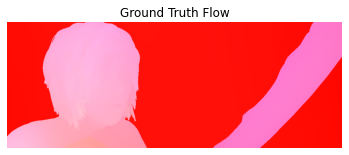

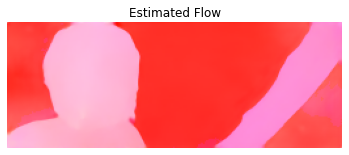

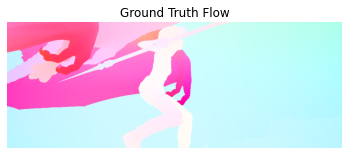

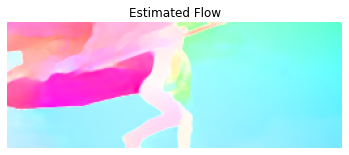

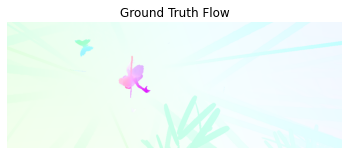

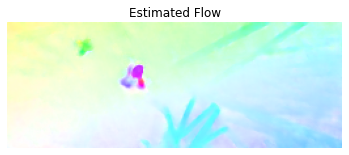

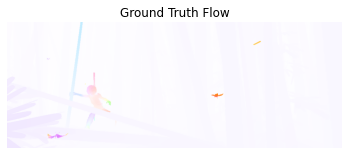

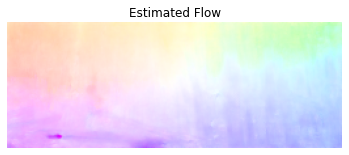

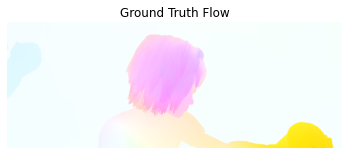

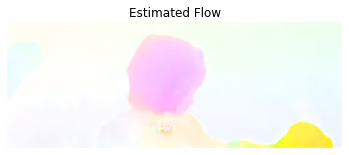


epe_val 4.063


In [ ]:
!gdown https://drive.google.com/uc?id=1xj_oTXRuK2L9W1v0xc6MbzK7_yTe7nfR # Download trained model
model = PWCNet().cuda()
model.load_state_dict(torch.load('model.pth'))
validate(model, val_loader, visualize = True)

## (e) Motion Magnification
Run the provided codes below visualize the magnified movie. You don't need to implement anything here.

In [ ]:
from  scipy import ndimage
def warp_flow(im2, vx, vy):
    """ 
    im2 warped according to (u,v).
    You'll use this function to warp an image (im2) to make it look like another image (im1), using
    the given flow field, i.e. we'll make the assumption that
    im1[y, x] = im2[y + vy[y, x], x + vx[y, x]] 
    """
    # this code is confusing because we assume vx and vy are the negative
    # of where to send each pixel, as in the results by ce's siftflow code
    y, x = np.mgrid[:im2.shape[0], :im2.shape[1]]
    dy = (y + vy).flatten()[np.newaxis, :]
    dx = (x + vx).flatten()[np.newaxis, :]
    # this says: a recipe for making im1 is to make a new image where im[y, x] = im2[y + flow[y, x, 1], x + flow[y, x, 0]]
    return np.concatenate([ndimage.map_coordinates(im2[..., i], np.concatenate([dy, dx])).reshape(im2.shape[:2] + (1,)) \
                            for i in range(im2.shape[2])], axis = 2)

class MpiSintel_mag(data.Dataset):
    def __init__(self,render_size=[384, 1024], train = False, root = ''):
        image_root = root
        self.render_size = render_size
        self.train = train
        self.image_list = sorted(glob(join(image_root, '*.png')))
        self.size = len(self.image_list)

        self.frame_size = read_gen(self.image_list[0]).shape

        if (self.render_size[0] < 0) or (self.render_size[1] < 0) or (self.frame_size[0]%64) or (self.frame_size[1]%64):
            self.render_size[0] = ( (self.frame_size[0])//64 ) * 64
            self.render_size[1] = ( (self.frame_size[1])//64 ) * 64

    def __getitem__(self, index):
        #print(self.image_list[index])
        img1 = read_gen(self.image_list[index])
        #print(img1)
        image_size = img1.shape[:2]
        cropper = StaticCenterCrop(image_size, self.render_size)
        image = list(map(cropper, [img1])) #2,H,W,3 
        image = np.array(image).transpose(0,3,1,2)
        image = torch.from_numpy(image.astype(np.float32))/255.
        return image  # 1,3,H,W

    def __len__(self):
        return self.size

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


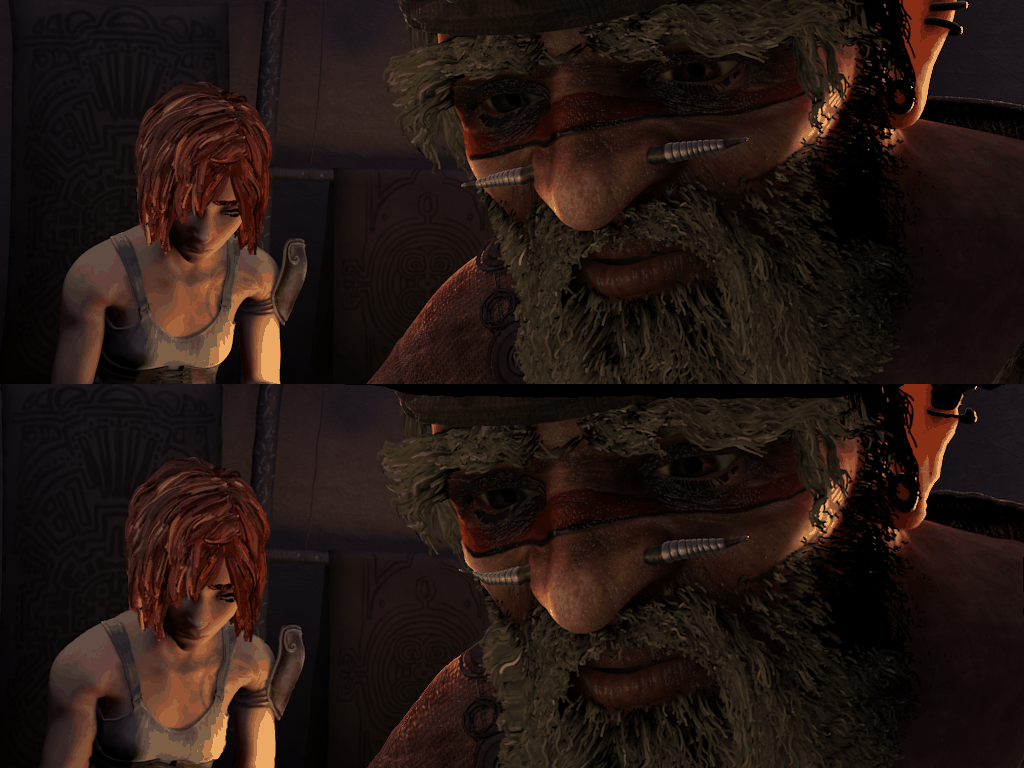

In [ ]:
ds = MpiSintel_mag(root='/content/MPI-Sintel-442/training/clean/shaman_2')
numFrames = len(ds)
H,W = ds.render_size
vx = np.zeros([numFrames,H,W])
vy = np.zeros([numFrames,H,W])

#parameters magnification
magnification = 5; #gain for small velocities
th = 30; # not magnify velocities with magnitude above this value
#Estimation motion
I0 = ds[0]
for n in range(1,5):
    In = ds[n]
    input_imgs = torch.cat((In,I0),1) #B,6,H,W
    output = model(input_imgs.cuda()) #a list of flow at different scale
    output_full_resolution = upsample2d_as(output, torch.zeros([1,2,384,1024])).cpu().detach().numpy() * 20
    #visualize_flow_array(output_full_resolution[0].transpose(1,2,0))
    vx[n-1,:,:], vy[n-1,:,:] = output_full_resolution[0,0], output_full_resolution[0,1]

import imageio
images = []
I0 = ds[0][0].numpy().transpose(1,2,0)
#Magnification and creation of new sequence. 
#Top half of the gif is the original movie. Bottom half of the gif is the magnified version.
for n in range(1,5):
    In = ds[n][0].numpy().transpose(1,2,0) # 1,3, H,W
    
    V = np.sqrt(vx[n-1,:,:]**2+vy[n-1,:,:]**2)
    vx_mag = vx[n-1,:,:]*(V>th) + magnification*vx[n-1,:,:]*(V<=th)
    vy_mag = vy[n-1,:,:]*(V>th) + magnification*vy[n-1,:,:]*(V<=th)
    In_hat = warp_flow(I0, vx_mag, vy_mag)

    In_hat = In*(V>th)[:,:,np.newaxis] + In_hat*(V<=th)[:,:,np.newaxis]

    frame = np.concatenate([In*255**2, In_hat*255**2])
    images.append(np.clip(frame,0,255).astype(np.uint8))

imageio.mimsave('movie.gif', images,format='GIF', fps=3)

#Load and visualize the original (top half) and manified movie (bottom half).
from IPython.display import Image
Image(open('movie.gif','rb').read())

# Convert Notebook to PDF


In [ ]:
# generate pdf
# %%capture
!git clone https://gist.github.com/bc5f1add34fef7c7f9fb83d3783311e2.git
!cp bc5f1add34fef7c7f9fb83d3783311e2/colab_pdf.py colab_pdf.py
from colab_pdf import colab_pdf
# change the name to your ipynb file name shown on the top left of Colab window
# Important: make sure that your file name does not contain spaces!
colab_pdf('Enpei_PS10_Optical_Flow.ipynb')

Cloning into 'bc5f1add34fef7c7f9fb83d3783311e2'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), done.
Mounted at /content/drive/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'